In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


In [28]:
import pandas as pd
import xarray as xr
import numpy as np
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot

#Load dataset and clean

In [4]:
dataset = xr.open_dataset('dataset_complete_for_model.nc')
dataset

<xarray.Dataset>
Dimensions:            (Days: 31, Hours: 24, lat: 33, long: 33)
Coordinates:
  * lat                (lat) float64 43.0 43.25 43.5 43.75 ... 50.5 50.75 51.0
  * long               (long) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
  * Days               (Days) int64 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * Hours              (Hours) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables: (12/21)
    EMISSIONS_2019     (lat, long, Days, Hours) float64 ...
    u10                (lat, long, Days, Hours) float64 ...
    v10                (lat, long, Days, Hours) float64 ...
    hcc                (lat, long, Days, Hours) float64 ...
    lcc                (lat, long, Days, Hours) float64 ...
    tcc                (lat, long, Days, Hours) float64 ...
    ...                 ...
    tcco               (lat, long, Days, Hours) float64 ...
    tcno2              (lat, long, Days, Hours) float64 ...
    tc_no              (lat, long, Days, Hours) float64 ...
    gtco3              (lat, long, Days, Hours) float64 ...
    tcwv               (lat, long, Days, Hours) float64 ...
    traffic            (lat, long, Days, Hours) float64 ...

In [5]:
df = dataset.to_dataframe()
df = df.dropna()
df.head()

EMISSIONS_2019       u10  ...       tcwv  traffic
Days Hours lat   long                            ...                    
1    1     43.25 4.00    1.575121e-12  2.410286  ...  13.522210      0.0
                 4.25    1.106813e-12  2.419098  ...  13.703443      0.0
                 4.50    8.896030e-13  2.427910  ...  13.884675      0.0
                 4.75    1.368838e-12  2.436721  ...  14.065908      0.0
                 5.00    1.921552e-11  2.065145  ...  14.054275      0.0

[5 rows x 21 columns]

#Normalizing

In [6]:
df_flat= df.reset_index()
df_flat.head()

,Days,Hours,lat,long,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,sp_hum,tot_wind,tmp_shifted_9,rel_hum_shifted_9,height,built,tcco,tcno2,tc_no,gtco3,tcwv,traffic
0,1,1,43.25,4.00,1.575121e-12,2.410286,-4.471569,0.00000,0.033220,0.033949,0.082098,0.251190,100328.223958,0.000004,5.160799,272.634288,0.000108,0.011574,0.000270,0.000945,0.000003,1.111883e-09,0.007828,13.522210,0.0
1,1,1,43.25,4.25,1.106813e-12,2.419098,-4.482981,0.00000,0.023336,0.023822,0.129154,0.202121,100443.010417,0.000004,5.156459,272.452199,0.000110,0.048225,0.001813,0.000945,0.000003,2.043325e-08,0.007804,13.703443,0.0
2,1,1,43.25,4.50,8.896030e-13,2.427910,-4.494392,0.00000,0.013452,0.013695,0.176211,0.153052,100557.796875,0.000004,5.152119,272.445004,0.000110,0.193866,0.004543,0.000946,0.000004,3.975461e-08,0.007780,13.884675,0.0
3,1,1,43.25,4.75,1.368838e-12,2.436721,-4.505804,0.00000,0.003567,0.003567,0.223267,0.103982,100672.583333,0.000004,5.147780,272.437809,0.000110,1.629372,0.052694,0.000946,0.000004,5.907598e-08,0.007756,14.065908,0.0
4,1,1,43.25,5.00,1.921552e-11,2.065145,-3.833641,0.00037,0.002378,0.002748,0.232694,0.096582,100300.658854,0.000004,4.438280,272.430613,0.000110,2.633102,0.075897,0.000942,0.000004,1.034015e-07,0.007734,14.054275,0.0


In [7]:
X = df_flat.drop(columns = ['EMISSIONS_2019'])
y = df_flat['EMISSIONS_2019']

input_variables = X.columns
target_variable = 'EMISSIONS_2019'

seed = 1234

In [8]:
scaler = MinMaxScaler()
df_sc = scaler.fit_transform(df_flat)

df_norm = pd.DataFrame(df_sc, columns=df_flat.columns)
df_norm.head()

,Days,Hours,lat,long,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,sp_hum,tot_wind,tmp_shifted_9,rel_hum_shifted_9,height,built,tcco,tcno2,tc_no,gtco3,tcwv,traffic
0,0.0,0.047619,0.0,0.000000,0.001189,0.556251,0.444753,5.551083e-17,0.033220,0.033949,0.102538,0.256059,0.918993,0.000000,0.302741,0.748620,0.118302,0.001282,0.001063,0.886255,0.231265,0.000104,0.309706,0.338870,8.775587e-09
1,0.0,0.047619,0.0,0.041667,0.000834,0.556734,0.444279,5.551083e-17,0.023336,0.023822,0.161310,0.206039,0.923901,0.003113,0.302485,0.737497,0.126068,0.005340,0.007139,0.887501,0.238563,0.005495,0.303180,0.344613,8.775587e-09
2,0.0,0.047619,0.0,0.083333,0.000670,0.557218,0.443805,5.551083e-17,0.013452,0.013695,0.220082,0.156018,0.928808,0.006226,0.302230,0.737057,0.126258,0.021467,0.017886,0.888746,0.245860,0.010885,0.296653,0.350356,8.775587e-09
3,0.0,0.047619,0.0,0.125000,0.001033,0.557702,0.443330,5.551083e-17,0.003567,0.003567,0.278854,0.105997,0.933715,0.009339,0.301974,0.736618,0.126448,0.180426,0.207463,0.889992,0.253157,0.016276,0.290127,0.356099,8.775587e-09
4,0.0,0.047619,0.0,0.166667,0.014561,0.537311,0.471267,3.696195e-04,0.002378,0.002748,0.290628,0.098454,0.917815,0.013192,0.260203,0.736178,0.126638,0.291573,0.298815,0.878827,0.312500,0.028643,0.284154,0.355731,8.775587e-09


#Baseline performance: Linear regression with 10 fold cross validation

In [9]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[input_variables], df_norm[target_variable], cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.354 StdDev 0.009


#Reduced variance feature selection

In [10]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", X.loc[:, mask].columns)
print("      Deleted Features = ", X.loc[:, ~mask].columns)

Reduced data set shape =  (378925, 12)
     Selected features =  Index(['Days', 'Hours', 'lat', 'long', 'u10', 'v10', 'sp', 'tot_wind',
       'tmp_shifted_9', 'height', 'tcwv', 'traffic'],
      dtype='object')
      Deleted Features =  Index(['hcc', 'lcc', 'tcc', 'cvl', 'cvh', 'sp_hum', 'rel_hum_shifted_9',
       'built', 'tcco', 'tcno2', 'tc_no', 'gtco3'],
      dtype='object')


In [11]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X.loc[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.333 StdDev 0.009


#Principal Component Analysis

In [12]:
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(df_norm[input_variables])
full_fitted_model.explained_variance_ratio_

array([2.38312914e-01, 1.26412589e-01, 1.16169088e-01, 9.75392854e-02,
       9.01725200e-02, 6.83577590e-02, 5.98318685e-02, 4.29279409e-02,
       3.39895250e-02, 2.53177070e-02, 1.77211092e-02, 1.56344517e-02,
       1.36649219e-02, 1.04617774e-02, 9.92862944e-03, 8.73351420e-03,
       6.40603297e-03, 4.76192986e-03, 4.28546362e-03, 3.39886589e-03,
       3.28443449e-03, 2.15959814e-03, 4.40294236e-04, 8.77801580e-05])

In [13]:
x_max=len(X.columns)
x_max

24

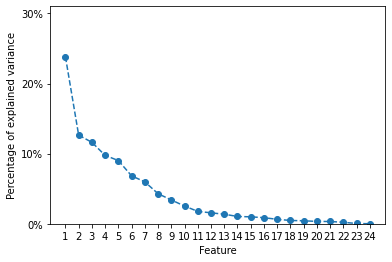

In [14]:
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.0,0.31,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.31,.1)]);
plt.ylim([0.0,0.31]);

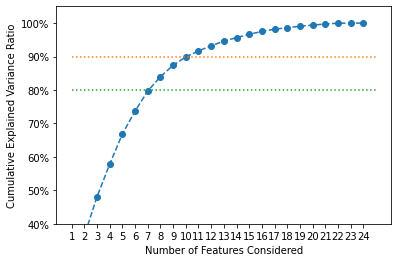

In [15]:
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,x_max],[.9,.9],':');
plt.plot([0,x_max],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [16]:
feature_selection_pca_model = PCA(n_components=10)
fitted_model = feature_selection_pca_model.fit(df_norm[input_variables])

X_selected_features_pca = fitted_model.transform(df_norm[input_variables])
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.899
Reduced data set shape = (378925, 10)


In [17]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.121 StdDev 0.003


#Random Forest feature importance

In [20]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(df_norm[input_variables], df_norm[target_variable])
importances = forest.feature_importances_
importances

array([0.00839417, 0.10861003, 0.06298052, 0.06139271, 0.00784965,
       0.00647805, 0.00779812, 0.00572044, 0.01086254, 0.07442906,
       0.08264706, 0.04061003, 0.00777465, 0.0045715 , 0.00646216,
       0.00548453, 0.1506404 , 0.15667064, 0.00445837, 0.00510467,
       0.02623543, 0.00780027, 0.01898123, 0.12804376])

Feature ranking:
 1. feature 17   built (0.157)
 2. feature 16  height (0.151)
 3. feature 23 traffic (0.128)
 4. feature  1   Hours (0.109)
 5. feature 10     cvh (0.083)
 6. feature  9     cvl (0.074)
 7. feature  2     lat (0.063)
 8. feature  3    long (0.061)
 9. feature 11      sp (0.041)
10. feature 20   tc_no (0.026)
11. feature 22    tcwv (0.019)
12. feature  8     tcc (0.011)
13. feature  0    Days (0.008)
14. feature  4     u10 (0.008)
15. feature 21   gtco3 (0.008)
16. feature  6     hcc (0.008)
17. feature 12  sp_hum (0.008)
18. feature  5     v10 (0.006)
19. feature 14 tmp_shifted_9 (0.006)
20. feature  7     lcc (0.006)
21. feature 15 rel_hum_shifted_9 (0.005)
22. feature 19   tcno2 (0.005)
23. feature 13 tot_wind (0.005)
24. feature 18    tcco (0.004)


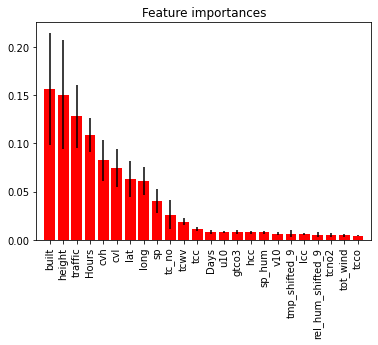

In [21]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[input_variables].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[input_variables].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[input_variables].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[input_variables].shape[1]), df_norm[input_variables].columns[indices],rotation=90)
plt.xlim([-1, df_norm[input_variables].shape[1]])
plt.show()

#Split train and test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_norm[input_variables], df_norm[target_variable], test_size=0.20, random_state=42)

#XGboost regressor

In [25]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train, verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE [s] = ', MAE )

[06:18:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE [s] =  0.012396585786902817


[]

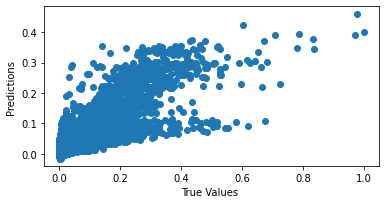

In [26]:
test_predictions = XGBpredictions

a = plt.axes(aspect='equal')
plt.scatter(y_test.values.tolist(), test_predictions.tolist())
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.plot()

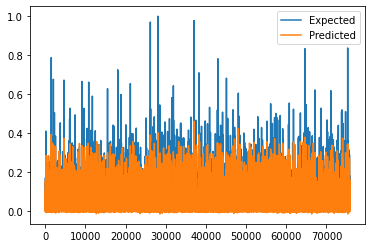

In [29]:
pyplot.plot(y_test.values.tolist(), label='Expected')
pyplot.plot(test_predictions.tolist(), label='Predicted')
pyplot.legend()
pyplot.show()